Decomposing the image by testing for mixtures of the SEDs of the peaks
-------------

Procedure: 

    1. Identify the high S/N portion of the image (the blended galaxy)
    2. Identify peaks within this
    3. Extract the SEDs of those peaks (subtracting local background)
    4. Fit all the pixels as mixtures of these SEDs
    
This version attempts to address the initial peak finding, trying to make it isolate the peaks better, in the presense of strong gradients.

In [20]:
import photutils
from astropy.stats import sigma_clipped_stats
from astropy.stats import gaussian_fwhm_to_sigma
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel
from photutils.utils import random_cmap
from astropy.io import fits
from makergb import *
import scipy.ndimage.filters as filters
from scipy.ndimage import morphology
from scipy.ndimage.measurements import label
from scipy import ndimage
from astropy.convolution import convolve
%matplotlib inline

img_scale : asinh
27.555202473 370190.799145
img_scale : asinh
9.08892079713 89883.7375963
img_scale : asinh
0.115558189546 2536.6883953


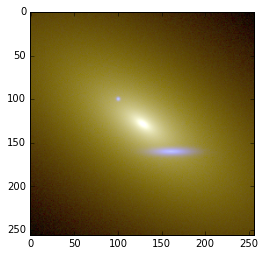

In [21]:
d = fits.getdata('deblending1cube.fits')
colorimage = makeRGB(d[:,:,4],d[:,:,2],d[:,:,0])
plt.imshow(colorimage)

First, generate a segmentation mask that encompasses all the pixels identified as above the threshold in any band (we would have to do something a bit more sophisticated in reality; maybe detection on a chisq image. This is just to give us segmentation image that we can use to drive the photutils deblender.

In [22]:
sigma = 2.0 * gaussian_fwhm_to_sigma    # FWHM = 2.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segimages = []
for i in range(d.shape[2]):
    threshold = photutils.detect_threshold(d[:,:,i], snr=2.)
    segimages += [photutils.detect_sources(d[:,:,i],threshold,npixels=5,filter_kernel=kernel)]

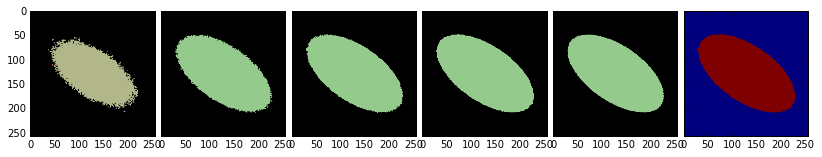

In [23]:
fig, ax = plt.subplots(1, 6, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.05, 0.05)
fig.set_size_inches(12, 3, forward=True)
segmask = np.zeros((d[:,:,0].shape),dtype=np.int16)
for i in range(d.shape[2]):
    rand_cmap = random_cmap(segimages[i].max + 1, random_state=12345)
    ax[i].imshow(segimages[i],cmap=rand_cmap)
    segmask += segimages[i]
segmask = np.choose(segmask>0,(0,1))
ax[5].imshow(segmask)

Try the local peak detection
First look at the rms typical difference between a single pixel and its immediate neighbors
Thought about using a circular region for this, but it's going to be slower and probably not going to 
matter if we are using small regions. If the full-width of the region is `npix`, then the circular
mask doesn't depart from a square mask until `npix = 7`. 

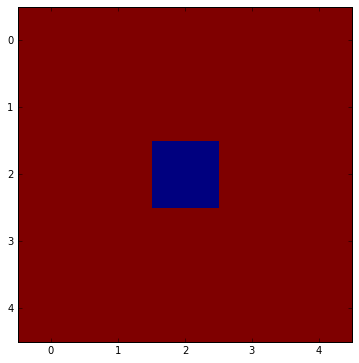

In [97]:
# Make a structuring element that leaves out the central pixel
npix=5
footprint = np.ones((npix,npix))
footprint[npix/2,npix/2]=0
plt.imshow(footprint,interpolation='nearest')

0.819257858614 0.753999053983 0.121904674883


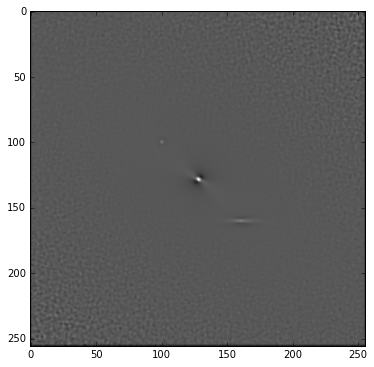

In [104]:
img = d[:,:,4]
cimg = convolve(img,kernel)
localback = filters.convolve(img,footprint/footprint.sum())
ratio = cimg/localback
print ratio[segmask].mean(),np.median(ratio[segmask]),ratio[segmask].std()
threshold = 3.*ratio[segmask].std()+np.median(ratio[segmask])
plt.imshow(ratio,cmap=plt.cm.gray)

Set a threshold at some multiple of this and mark regions where the maximum within the region minus the median over the region is more than this threshold

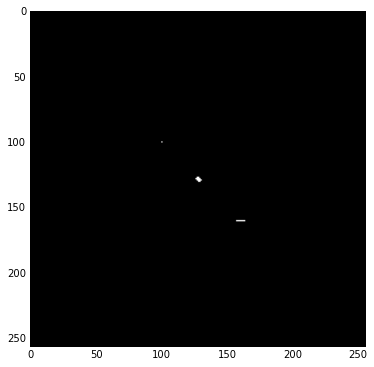

In [105]:
plt.rcParams['figure.figsize'] = (10, 6)
#peakmask = filters.maximum_filter(cimg,npix)/filters.median_filter(cimg,npix) > threshold
peakmask = cimg/localback > threshold
plt.imshow(peakmask*segmask,cmap=plt.cm.gray)

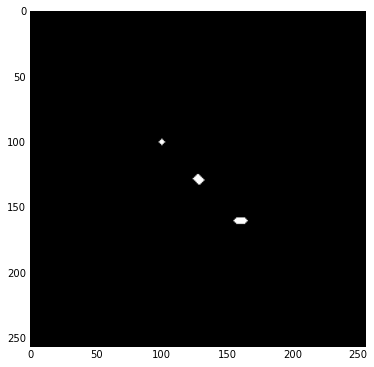

In [106]:
dilated_peakmask = morphology.binary_dilation(peakmask*segmask,iterations=2)
dilated_peakmask = morphology.binary_opening(dilated_peakmask,iterations=1)
dilated_peakmask = morphology.binary_closing(dilated_peakmask,iterations=1)
plt.imshow(dilated_peakmask,cmap=plt.cm.gray)

dtype('int32')

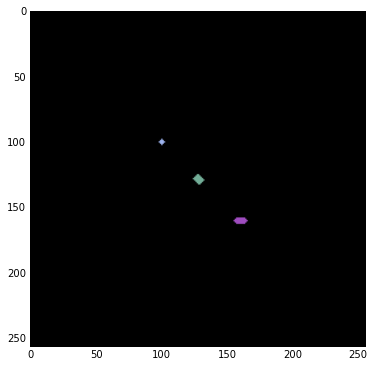

In [107]:
labeled_array,numfeatures = label(dilated_peakmask)
rand_cmap = random_cmap(numfeatures + 1, random_state=1234)
plt.imshow(labeled_array,cmap=rand_cmap)
labeled_array.dtype

Make this into a script

In [111]:
def extract_peaks(img,kernel_fwhm=2.,npix=5,sigma_thresh=3.,
                  dilate_iter=2):
    # Create the footprint (square array of ones with 0 in the center)
    if (npix % 2) == 0:
        print "npix must be odd!"
    footprint = np.ones((npix,npix))
    footprint[npix/2,npix/2]=0
    # Convolve with this normalized footprint to create the local background for each pixel
    localback = filters.convolve(img,footprint/footprint.sum())
    # Create the Gaussian convolution kernel and convolve the image
    sigma = kernel_fwhm * gaussian_fwhm_to_sigma    # FWHM = 2.
    kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
    kernel.normalize()
    cimg = convolve(img,kernel)
    # Look at the ratio of the central pixel to the median in the footprint
    ratio = cimg/localback
    threshold = sigma_thresh*ratio[segmask].std()+np.median(ratio[segmask])
    peakmask = cimg/localback > threshold
    dilated_peakmask = morphology.binary_dilation(peakmask*segmask,iterations=dilate_iter)
    dilated_peakmask = morphology.binary_opening(dilated_peakmask,iterations=1)
    dilated_peakmask = morphology.binary_closing(dilated_peakmask,iterations=1)
    labeled_array,numfeatures = label(dilated_peakmask)
    return labeled_array,numfeatures

In [112]:
segcube = np.zeros((d.shape),dtype=np.int32)
maxfeatures=0
for i in range(d.shape[2]):
    segcube[:,:,i],n = extract_peaks(d[:,:,i])
    maxfeatures = max(maxfeatures,n)

Compare the segmentations from the different bands and combine them with a bit of erosion and dilation to get rid of noise

3
num =  3


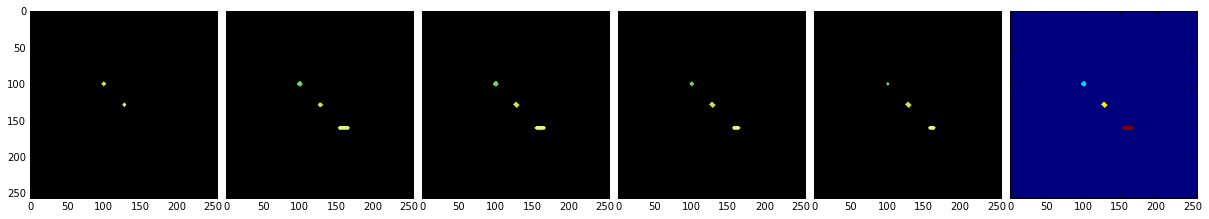

In [113]:
print maxfeatures
fig, ax = plt.subplots(1, 6, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.05, 0.05)
fig.set_size_inches(18, 5, forward=True)
peakmask = np.zeros((d[:,:,0].shape),dtype=np.int32)
for i in range(d.shape[2]):
    rand_cmap = random_cmap(maxfeatures + 1, random_state=12345)
    ax[i].imshow(segcube[:,:,i],cmap=rand_cmap)
    peakmask += segcube[:,:,i]
peakmask = np.choose(peakmask>0,(0,1))
#peakmask = morphology.binary_opening(peakmask,iterations=3)
lseg,num = label(peakmask)
print "num = ",num
ax[5].imshow(lseg)

Extract SEDs from within the regions defined by this peapmap.
--------
Local background is taken from the immediately-bordering pixels? How do we get those...try dilating and subtracting the source mask. Looks pretty good.

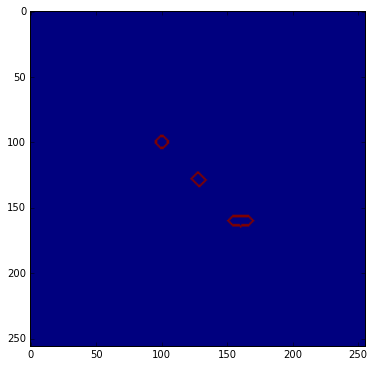

In [115]:
border = morphology.binary_dilation(peakmask,iterations=2)-peakmask
plt.imshow(border)

So the next function is going to step through the source labels, create the border, take the mean within the border for the background and subtract that from the pixels identified as the sources. It will return the background-subtracted SED summed over the source pixels for each source. It also returns the backgrounds for debugging purposes.

In [116]:
def extract_seds(img,lseg):
    nband = img.shape[2]
    bkgds = []
    sources = []
    for i in range(1,lseg.max()+1):
        bkgd = np.zeros((nband),dtype=np.float64)
        source = np.zeros((nband),dtype=np.float64)
        sourcemask = lseg==i
        border = morphology.binary_dilation(sourcemask,iterations=2)-sourcemask
        print i,sourcemask.sum(),border.sum()
        for b in range(nband):
            bkgd[b] = img[:,:,b][border].mean()
            source[b] = (img[:,:,b][sourcemask]-bkgd[b]).sum()
        bkgds += [bkgd]
        sources += [source]
    return sources,bkgds

In [117]:
seds,bkgds = extract_seds(d,lseg)
normseds = [ss/ss.sum() for ss in seds]

1 37 44
2 40 44
3 74 76


/Users/ferguson/anaconda/envs/iraf27/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


Plot up the SEDs. They look qualitatively like the input SEDs, so this is gratifying.

In [118]:
skyflux = np.array([ 0.79487966,  2.54955216,  3.96139216,  4.36853847,  4.44948121])
nband=len(skyflux)

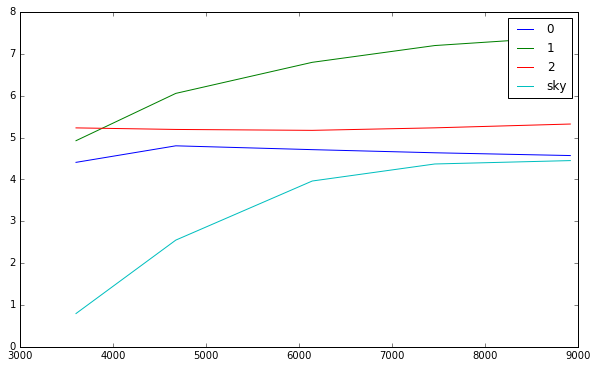

In [119]:
wave=np.array([ 3602.68189234,  4675.81266513,  6142.78798384,  7460.59398274,
        8918.13029846])
for i,ss in enumerate(seds):
    plt.plot(wave,np.log10(ss),label=i)
plt.plot(wave,skyflux,label='sky')
plt.legend()
normseds = [ss/ss.sum() for ss in seds]

For this proof of concept, we'll subtract true sky levels. In reality this would be determined from a larger image. 

Sky subtraction needs a bit more thought. Since we've subtracted a local background in making these SEDs, we've in principle already subtracted it. However, we need to take off this constant component before fitting the pixels, since we aren't doing local background subtraction in the fitting step.

In [120]:
class composite_sed:
    def __init__(self,seds):
        self.sedlist = np.vstack(seds)
        self.X = self.sedlist.T
    def fit(self,obssed,verbose=False):
        a,resid,rank,s = np.linalg.lstsq(self.X,obssed)
        r2 = 1-resid/(len(obssed)*obssed.var())
        if verbose:
            print "a= ",a
            print "resd= ",resid
            print "r2= ",r2
        return a

Try fitting the central pixel of the bright galaxy

In [121]:
# The bright galaxy
pixsed = d[128,128,:]-skyflux
component_seds = [s for s in seds]
cfit = composite_sed(component_seds)
component_norm = cfit.fit(pixsed,verbose=True)

a=  [ 0.01149029  0.12405733 -0.00257403]
resd=  [ 413835.33473713]
r2=  [ 0.99999994]


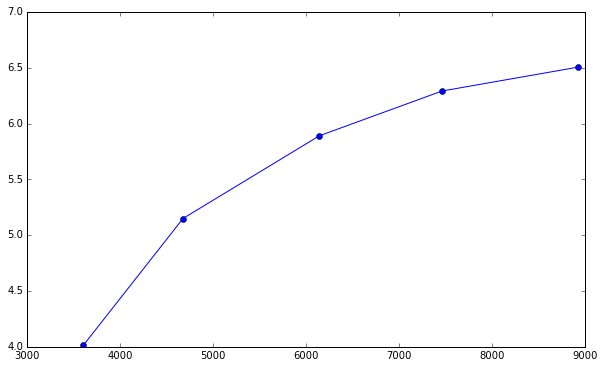

In [122]:
fitsed = np.zeros((len(skyflux)),dtype=np.float64)
for a,s in zip(component_norm,component_seds):
     fitsed += a*s 
plt.plot(wave,np.log10(pixsed),'bo')
plt.plot(wave,np.log10(fitsed))

How about the fainter galaxy?

a=  [-0.00110618  0.00042986  0.05687011]
resd=  [ 25515.56204353]
r2=  [ 0.9998123]


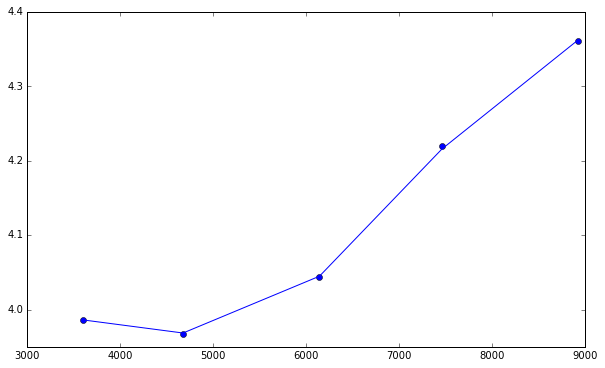

In [123]:
# The bright galaxy
pixsed = d[160,160,:]-skyflux
component_seds = [s for s in seds]
cfit = composite_sed(component_seds)
component_norm = cfit.fit(pixsed,verbose=True)
# Plot the result
fitsed = np.zeros((len(skyflux)),dtype=np.float64)
for a,s in zip(component_norm,component_seds):
     fitsed += a*s 
plt.plot(wave,np.log10(pixsed),'bo')
plt.plot(wave,np.log10(fitsed))

a=  [ 0.19539356  0.00054578  0.00031107]
resd=  [ 8325.86261553]
r2=  [ 0.99994261]


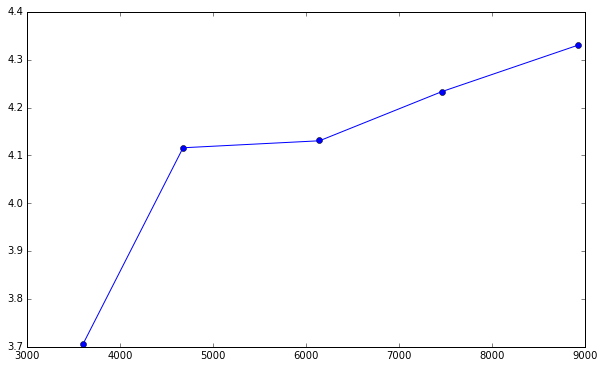

In [124]:
# The star
pixsed = d[100,100,:]-skyflux
component_seds = [s for s in seds]
cfit = composite_sed(component_seds)
component_norm = cfit.fit(pixsed,verbose=True)
# Plot the result
fitsed = np.zeros((len(skyflux)),dtype=np.float64)
for a,s in zip(component_norm,component_seds):
     fitsed += a*s 
plt.plot(wave,np.log10(pixsed),'bo')
plt.plot(wave,np.log10(fitsed))

Try making a composite image by fitting all the pixels within the segmentation region

In [125]:
coefficient_cube=np.zeros((256,256,num),dtype=np.float64)
summed_cube=np.zeros((256,256,nband),dtype=np.float64)
component_cubes = []
for i in range(num):
    component_cubes += [0.*summed_cube]
component_seds = [s for s in seds]
cfit = composite_sed(component_seds)
for i in range(256):
    for j in range(256):
        if segmask[i,j]:
            pixsed = d[i,j,:]-skyflux
            coefficient_cube[i,j,:]=np.array(cfit.fit(pixsed))
            for n in range(num):
                coeff = coefficient_cube[i,j,n]
                summed_cube[i,j,:] += coeff*component_seds[n]
                component_cubes[n][i,j,:] = coeff*component_seds[n]
            summed_cube[i,j,:] += skyflux

img_scale : asinh
0.0 369876.731048
img_scale : asinh
0.0 89851.5775621
img_scale : asinh
0.0 2541.17449066


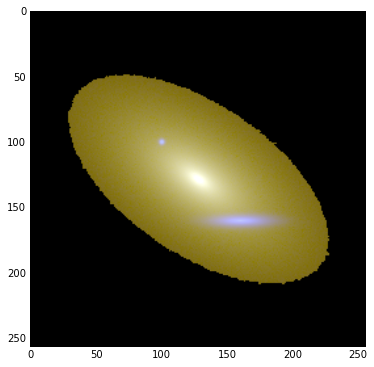

In [126]:
model_colorimage = makeRGB(summed_cube[:,:,4],summed_cube[:,:,2],summed_cube[:,:,0])
plt.imshow(model_colorimage)

img_scale : asinh
0.0 228.365953108
img_scale : asinh
0.0 316.061557093
img_scale : asinh
0.0 157.058138604
img_scale : asinh
0.0 369888.688247
img_scale : asinh
0.0 89972.8547703
img_scale : asinh
0.0 1206.05525498
img_scale : asinh
0.0 2113.48861864
img_scale : asinh
0.0 1492.87977808
img_scale : asinh
0.0 1709.71220275


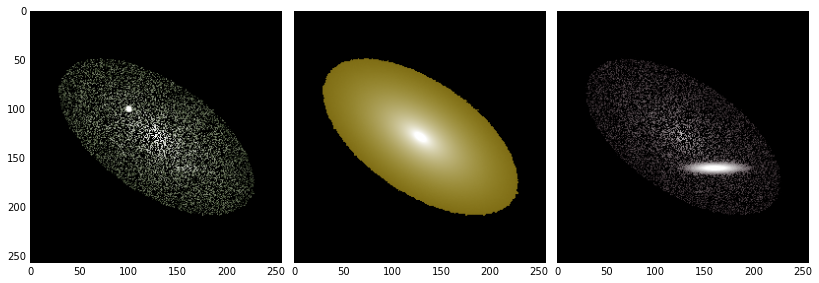

In [127]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.05, 0.05)
fig.set_size_inches(12, 6, forward=True)
for i in range(num):
    comp = component_cubes[i]
    ci = makeRGB(comp[:,:,4],comp[:,:,2],comp[:,:,0])
    ax[i].imshow(ci)